In [ ]:
"""
Created on 2019/02/24

WGAN-GP from another source using Keras

Source: https://github.com/bojone/gan/blob/master/keras/wgan_gp_celeba.py
"""

"""
觀念補充:

卷積output圖片size計算: N=(W−F+2P)/S+1
    輸入圖片矩陣為：WxW 
    卷積核大小，kernel_size：FxF 
    步長strides：S 
    邊界擴充padding的值：P

逆卷積output圖片size計算: W=(N−1)∗S−2P+F
    輸入圖片矩陣為：NxN 
    卷積核大小，kernel_size：FxF 
    步長strides：S 
    邊界擴充padding的值：P

"""

# Import

In [2]:
import numpy as np
from scipy import misc
import glob
import imageio
from keras.models import Model, load_model
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data preparation

## CelebA

In [14]:
if not os.path.exists('celebA_samples'):
    os.mkdir('celebA_samples')

imgs_path = Path("/home/rossleecooloh/workspace/Dateset/CelebA/img_align_celeba/")

def read_img(imgs_path, img_dim=64):
    # imgs = []
    # for i, img in enumerate(imgs_path.rglob("*.jpg")):
    input_image = cv2.imread(str(imgs_path))
    input_image = cv2.resize(input_image, (img_dim, img_dim))
    input_image = input_image[:, :, ::-1] # BGR -> RGB
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    # imgs.append(input_image)
    
    return input_image

imgs = list(imgs_path.rglob("*.jpg"))

# x_train = read_imgs(imgs_path)  # 20幾萬張，太大，先取50000張
# np.random.shuffle(x_train)
# x_train = x_train[:50000]

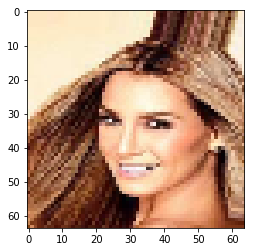

In [15]:
plt.imshow(read_img(imgs[0]))

## Complex

In [3]:
if not os.path.exists('samples'):
    os.mkdir('samples')

imgs_path = Path("/home/rossleecooloh/workspace/Dateset/thumbnails_features_deduped_publish")

def read_img(imgs_path, img_dim=64):
    # imgs = []
    # for i, img in enumerate(imgs_path.rglob("*.jpg")):
    input_image = cv2.imread(str(imgs_path))
    input_image = cv2.resize(input_image, (img_dim, img_dim))
    input_image = input_image[:, :, ::-1] # BGR -> RGB
    # input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = input_image / 255.0
    # imgs.append(input_image)
    
    return input_image

imgs = list(imgs_path.rglob("*.jpg"))

# x_train = read_imgs(imgs_path)  # 20幾萬張，太大，先取50000張
# np.random.shuffle(x_train)
# x_train = x_train[:50000]

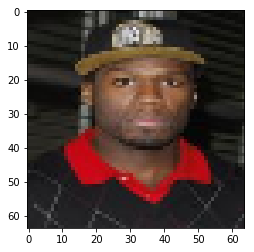

In [4]:
plt.imshow(read_img(imgs[0]))

## Image training generator

In [16]:
def imread(f):
    x = misc.imread(f)
    x = x[center_height:center_height + width, :]
    x = misc.imresize(x, (img_dim, img_dim))
    return x.astype(np.float32) / 255 * 2 - 1

def data_generator(batch_size=32):
    X = []
    while True:
        np.random.shuffle(imgs)
        for path in imgs:
            X.append(read_img(path))
            if len(X) == batch_size:
                X = np.array(X)
                yield X
                X = []

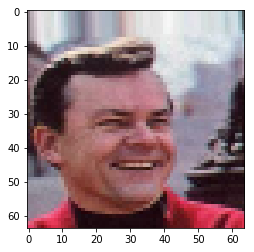

In [17]:
x = data_generator()
plt.imshow(next(x)[0]) # (32, 64, 64, 3)

# Model

## Hyperarameters

In [18]:
height, width = read_img(imgs[0]).shape[:2]
# center_height = int((height - width) / 2)
img_dim = 64
z_dim = 100

## Discriminator

In [19]:
# 判别器
x_in = Input(shape=(img_dim, img_dim, 3))
x = x_in

x = Conv2D(img_dim,
           (5, 5),
           strides=(2, 2),
           padding='same')(x)
x = LeakyReLU()(x)

for i in range(3):
    x = Conv2D(img_dim * 2**(i + 1), # 64 * 2^0/ 2^1/ 2^2
               (5, 5),
               strides=(2, 2),
               padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

x = Flatten()(x)
x = Dense(1, use_bias=False)(x)

d_model = Model(x_in, x)
d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         819456    
__________

## Generator

In [20]:
height, width = read_img(imgs[0]).shape[:2]
# center_height = int((height - width) / 2)
img_dim = 64
z_dim = 100

z_in = Input(shape=(z_dim, ))

z = Dense(4 * 4 * img_dim * 8)(z_in)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Reshape((4, 4, img_dim * 8))(z)

for i in range(3):
    z = Conv2DTranspose(img_dim * 4 // 2**i,
                        (5, 5),
                        strides=(2, 2),
                        padding='same')(z)  # W=(N−1)∗S−2P+F
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

z = Conv2DTranspose(3,  # 3 channels
                    (5, 5),
                    strides=(2, 2),
                    padding='same')(z)
z = Activation('tanh')(z) # -1 ~ 1

g_model = Model(z_in, z)
g_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_6 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 256)         1024      
__________

# Integrated Training

## Trained on CelebA

In [21]:
g_model = load_model('g_model_align_celebA.h5')
d_model = load_model('d_model_align_celebA.h5')

# 訓練Discriminator
x_in = Input(shape=(img_dim, img_dim, 3))
z_in = Input(shape=(z_dim, ))
g_model.trainable = False
d_model.trainable = True


print("-" * 10 + "Train Discriminator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()

# 隨機挑一對真假圖interpolate (lambda * x[0] + lambda * x[1])
def interpolating(x):
    u = K.random_uniform((K.shape(x[0])[0],) + (1,) * (K.ndim(x[0]) - 1))
    return x[0] * u + x[1] * (1 - u)

x_fake = g_model(z_in)
x_inter = Lambda(interpolating)([x_in, x_fake])
x_real_score = d_model(x_in)
x_fake_score = d_model(x_fake)
x_inter_score = d_model(x_inter) # 在P_penalty空間的圖分數

grads = K.gradients(x_inter_score, [x_inter])[0] # 求P_penalty圖分數的gradient
# range要加個list包在外
# Error Ref: https://github.com/tensorflow/models/issues/3705#issuecomment-375563179
grad_norms = K.sqrt(K.sum(grads**2, list(range(1, K.ndim(grads)))) + 1e-9) # 在grads上取Norm_2

d_train_model = Model([x_in, z_in],
                      [x_real_score, x_fake_score, x_inter_score])
# 加上grad_penalty當作loss的寫法百百種，可直接加上去，也可像下面(-1再平方)。
# 原文是hinge loss，grad_penalty沒有大於1，這項的loss就等於0
# https://github.com/EmilienDupont/wgan-gp/blob/master/training.py (另一種寫法可參考)
d_loss = K.mean(-(x_real_score - x_fake_score)) + 10 * K.mean((grad_norms - 1)**2)
d_train_model.add_loss(d_loss)
d_train_model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5))


# 訓練Generator
g_model.trainable = True
d_model.trainable = False
x_fake_score = d_model(g_model(z_in))

# D會給假圖越小越好的分數，所以Train G的時候，把這個分數拿來當loss時，就要讓這個分數越高越好(真圖分數)
# 所以loss要加上負號(因為gradient descent會讓它越來越低)
g_train_model = Model(z_in, x_fake_score)
g_train_model.add_loss(K.mean(-x_fake_score))  # loss越小越好 -> 讓fake_score變高(圖越逼真越好)
g_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))


# 检查模型结构
print("-" * 10 + "Train Generator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_train_model.summary()

# sample + 畫圖
def sample_images(path):
    n = 9
    figure = np.zeros((img_dim * n, img_dim * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1, z_dim)
            x_sample = g_model.predict(z_sample)
            digit = x_sample[0]
            figure[i * img_dim:(i + 1) * img_dim,
                   j * img_dim:(j + 1) * img_dim] = digit
    # figure = (figure + 1) / 2 * 255
    figure = figure * 255
    figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
    figure = np.round(figure, 0).astype(int)
    cv2.imwrite(path, figure)


iters_per_drawing = 100
total_iter = 10000
batch_size = 128
img_generator = data_generator(batch_size)

for i in range(total_iter):
    for j in range(2):
        z_sample = np.random.randn(batch_size, z_dim)
        d_loss = d_train_model.train_on_batch(x=[next(img_generator), z_sample], y=None)
    for j in range(1):
        z_sample = np.random.randn(batch_size, z_dim)
        g_loss = g_train_model.train_on_batch(x=z_sample, y=None)
    if i % 10 == 0:
        print('iter: %s, d_loss: %s, g_loss: %s' % (i, d_loss, g_loss))
    if i % iters_per_drawing == 0:
        sample_images('celebA_samples/test_%s.png' % i)
        # g_train_model.save_weights('./g_train_model.weights')
g_model.save("g_model_align_celebA.h5")
d_model.save("d_model_align_celebA.h5")

----------Train Discriminator----------
Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8192)              32768     
_________________________________________________________________
activation_6 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_12 (Ba

iter: 0, d_loss: 21.210999, g_loss: 3.1964521
iter: 10, d_loss: -9.491017, g_loss: 7.3248653
iter: 20, d_loss: -7.85375, g_loss: 4.7734723
iter: 30, d_loss: -10.142753, g_loss: 0.4372437
iter: 40, d_loss: -7.945615, g_loss: -0.19951983
iter: 50, d_loss: -5.5903063, g_loss: -2.5132751
iter: 60, d_loss: -3.8308403, g_loss: -6.261216
iter: 70, d_loss: -5.184437, g_loss: -6.188792
iter: 80, d_loss: -7.323287, g_loss: 4.165901
iter: 90, d_loss: -8.085378, g_loss: 8.740654
iter: 100, d_loss: -5.7121058, g_loss: 4.3615103
iter: 110, d_loss: -7.3121066, g_loss: 3.2782688
iter: 120, d_loss: -8.193713, g_loss: 6.7851496
iter: 130, d_loss: -6.7642775, g_loss: 7.5778103
iter: 140, d_loss: -8.214403, g_loss: 11.365473
iter: 150, d_loss: -6.0919867, g_loss: 6.3479824
iter: 160, d_loss: -7.3719034, g_loss: 8.05579
iter: 170, d_loss: -7.033013, g_loss: 9.4151325
iter: 180, d_loss: -5.19845, g_loss: 3.6994731
iter: 190, d_loss: -5.885257, g_loss: 9.34763
iter: 200, d_loss: -5.718965, g_loss: 3.4255843


iter: 1660, d_loss: -2.215674, g_loss: 1.8310728
iter: 1670, d_loss: -2.3497143, g_loss: 3.6595457
iter: 1680, d_loss: -1.9328809, g_loss: 0.90230674
iter: 1690, d_loss: -1.8084557, g_loss: 4.158929
iter: 1700, d_loss: -2.0754309, g_loss: 2.0657787
iter: 1710, d_loss: -1.8521831, g_loss: 0.18019195
iter: 1720, d_loss: -2.0954702, g_loss: 1.7509081
iter: 1730, d_loss: -2.070942, g_loss: 1.8066772
iter: 1740, d_loss: -1.4288704, g_loss: 1.6657034
iter: 1750, d_loss: -1.7639859, g_loss: -0.985736
iter: 1760, d_loss: -1.8635101, g_loss: 0.43273866
iter: 1770, d_loss: -1.6646897, g_loss: 1.3052071
iter: 1780, d_loss: -1.7331319, g_loss: -0.5774974
iter: 1790, d_loss: -1.6282402, g_loss: -0.0870366
iter: 1800, d_loss: -1.9204801, g_loss: 0.9152744
iter: 1810, d_loss: -1.7150143, g_loss: -0.68446064
iter: 1820, d_loss: -1.9194276, g_loss: 3.1574795
iter: 1830, d_loss: -2.0138814, g_loss: 2.5449138
iter: 1840, d_loss: -2.2569613, g_loss: 4.4427824
iter: 1850, d_loss: -1.6510779, g_loss: 1.0121

iter: 3310, d_loss: -0.77477825, g_loss: -9.09232
iter: 3320, d_loss: -0.6507415, g_loss: -10.421399
iter: 3330, d_loss: -1.0907458, g_loss: -10.316204
iter: 3340, d_loss: -0.9890801, g_loss: -3.46436
iter: 3350, d_loss: -0.4296171, g_loss: -8.626781
iter: 3360, d_loss: -0.7720381, g_loss: -10.489864
iter: 3370, d_loss: -0.89691186, g_loss: -10.015558
iter: 3380, d_loss: -1.5780967, g_loss: -13.053215
iter: 3390, d_loss: -1.233858, g_loss: -17.884815
iter: 3400, d_loss: -0.6140829, g_loss: -20.31271
iter: 3410, d_loss: -0.904123, g_loss: -19.801228
iter: 3420, d_loss: -0.9828043, g_loss: -19.60077
iter: 3430, d_loss: -2.269162, g_loss: -7.481611
iter: 3440, d_loss: -1.3507941, g_loss: -7.820842
iter: 3450, d_loss: -1.2776755, g_loss: -13.942013
iter: 3460, d_loss: -0.41695464, g_loss: -14.830533
iter: 3470, d_loss: -2.1102862, g_loss: -13.4113035
iter: 3480, d_loss: 0.0070358515, g_loss: -12.312938
iter: 3490, d_loss: -1.2035435, g_loss: -8.509848
iter: 3500, d_loss: -1.2412565, g_loss

iter: 4930, d_loss: -1.4087895, g_loss: 2.285281
iter: 4940, d_loss: -1.4857806, g_loss: 1.1420879
iter: 4950, d_loss: -1.5058851, g_loss: 0.8010512
iter: 4960, d_loss: -1.4374216, g_loss: 1.1448027
iter: 4970, d_loss: -1.5319101, g_loss: -1.5411036
iter: 4980, d_loss: -1.3549392, g_loss: -0.8707747
iter: 4990, d_loss: -1.4763062, g_loss: -0.5468954
iter: 5000, d_loss: -1.6432058, g_loss: -3.0899167
iter: 5010, d_loss: -1.4763961, g_loss: -5.2901125
iter: 5020, d_loss: -1.7262397, g_loss: -1.5089014
iter: 5030, d_loss: -0.88691664, g_loss: -3.5075727
iter: 5040, d_loss: -1.2012788, g_loss: 4.135778
iter: 5050, d_loss: -1.76517, g_loss: 3.7324572
iter: 5060, d_loss: -1.3160527, g_loss: 1.4604795
iter: 5070, d_loss: -1.2528057, g_loss: 1.7971104
iter: 5080, d_loss: -1.378066, g_loss: 0.02857351
iter: 5090, d_loss: -1.5193987, g_loss: -2.403213
iter: 5100, d_loss: -1.4740782, g_loss: -0.050460413
iter: 5110, d_loss: -1.5735005, g_loss: -0.45309883
iter: 5120, d_loss: -1.479605, g_loss: -2

iter: 6570, d_loss: -1.4010677, g_loss: 2.3631253
iter: 6580, d_loss: -1.4767182, g_loss: 8.086943
iter: 6590, d_loss: -1.1545545, g_loss: 1.1299242
iter: 6600, d_loss: -1.3357959, g_loss: 6.99434
iter: 6610, d_loss: -1.0655123, g_loss: 6.0438213
iter: 6620, d_loss: -0.95823294, g_loss: 4.209903
iter: 6630, d_loss: -1.1592748, g_loss: 2.939196
iter: 6640, d_loss: -1.3694438, g_loss: 1.213258
iter: 6650, d_loss: -1.0737785, g_loss: 2.167973
iter: 6660, d_loss: -1.0491784, g_loss: 0.48029855
iter: 6670, d_loss: -1.3790541, g_loss: -1.5684686
iter: 6680, d_loss: -0.88075393, g_loss: 1.4626149
iter: 6690, d_loss: -0.83495915, g_loss: -1.6433706
iter: 6700, d_loss: -2.0840478, g_loss: 2.8062103
iter: 6710, d_loss: -1.0637301, g_loss: 1.2114271
iter: 6720, d_loss: -0.7675474, g_loss: -1.108906
iter: 6730, d_loss: -1.1700883, g_loss: -2.7961454
iter: 6740, d_loss: -0.58060557, g_loss: -2.8222435
iter: 6750, d_loss: -1.234005, g_loss: -3.252396
iter: 6760, d_loss: -1.4909611, g_loss: -2.919903

iter: 8180, d_loss: -0.67933285, g_loss: -22.511246
iter: 8190, d_loss: -0.35185608, g_loss: -23.00298
iter: 8200, d_loss: -0.31606174, g_loss: -19.188198
iter: 8210, d_loss: -1.1691848, g_loss: -16.389132
iter: 8220, d_loss: -0.33904925, g_loss: -19.932579
iter: 8230, d_loss: -0.48864186, g_loss: -13.087097
iter: 8240, d_loss: 0.26092446, g_loss: -13.234375
iter: 8250, d_loss: -0.4867543, g_loss: -15.639032
iter: 8260, d_loss: -0.4310705, g_loss: -15.058559
iter: 8270, d_loss: -0.572373, g_loss: -18.75761
iter: 8280, d_loss: -1.1429108, g_loss: -14.223015
iter: 8290, d_loss: -0.41014564, g_loss: -15.35825
iter: 8300, d_loss: -0.3447703, g_loss: -14.762043
iter: 8310, d_loss: -0.19992588, g_loss: -15.079919
iter: 8320, d_loss: -1.0626092, g_loss: -26.321577
iter: 8330, d_loss: -0.502755, g_loss: -23.126354
iter: 8340, d_loss: -0.9004617, g_loss: -22.091213
iter: 8350, d_loss: -0.20360759, g_loss: -16.482227
iter: 8360, d_loss: 0.5912137, g_loss: -21.377338
iter: 8370, d_loss: -0.586893

iter: 9800, d_loss: -2.0356395, g_loss: -9.519435
iter: 9810, d_loss: -0.76670754, g_loss: -9.743282
iter: 9820, d_loss: 0.2970925, g_loss: -4.315425
iter: 9830, d_loss: -0.027258597, g_loss: 5.899777
iter: 9840, d_loss: -0.6129035, g_loss: -3.8577907
iter: 9850, d_loss: -0.24910778, g_loss: -0.19616497
iter: 9860, d_loss: -0.03450112, g_loss: -13.079239
iter: 9870, d_loss: -1.9399903, g_loss: -11.68672
iter: 9880, d_loss: 0.124064915, g_loss: -11.183071
iter: 9890, d_loss: -0.21830383, g_loss: -15.312672
iter: 9900, d_loss: -0.6490522, g_loss: -21.825695
iter: 9910, d_loss: -1.455861, g_loss: -12.105547
iter: 9920, d_loss: -1.3974378, g_loss: -7.579856
iter: 9930, d_loss: 0.6527678, g_loss: -10.388134
iter: 9940, d_loss: -0.23811454, g_loss: -7.001008
iter: 9950, d_loss: -0.30070165, g_loss: -16.478241
iter: 9960, d_loss: 0.05161287, g_loss: -21.065765
iter: 9970, d_loss: -0.8772231, g_loss: -15.811005
iter: 9980, d_loss: -1.9210049, g_loss: -14.934336
iter: 9990, d_loss: -0.32784665,

In [13]:
g_model = load_model('g_model_align_celebA.h5')

n = 9
img_dim = 64
z_dim = 100
figure = np.zeros((img_dim * n, img_dim * n, 3))
for i in range(n):
    for j in range(n):
        z_sample = np.random.randn(1, z_dim)
        x_sample = g_model.predict(z_sample)
        digit = x_sample[0]
        figure[i * img_dim:(i + 1) * img_dim,
               j * img_dim:(j + 1) * img_dim] = digit
# figure = (figure + 1) / 2 * 255
figure = figure * 255
figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
figure = np.round(figure, 0).astype(int)
cv2.imwrite('celebA_samples/ppt_1.png', figure)

True

## Trained on Complex

In [13]:
g_model = load_model('g_model_complex.h5')
d_model = load_model('d_model_complex.h5')

# 訓練Discriminator
x_in = Input(shape=(img_dim, img_dim, 3))
z_in = Input(shape=(z_dim, ))
g_model.trainable = False
d_model.trainable = True


print("-" * 10 + "Train Discriminator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_model.summary()

# 隨機挑一對真假圖interpolate (lambda * x[0] + lambda * x[1])
def interpolating(x):
    u = K.random_uniform((K.shape(x[0])[0],) + (1,) * (K.ndim(x[0]) - 1))
    return x[0] * u + x[1] * (1 - u)

x_fake = g_model(z_in)
x_inter = Lambda(interpolating)([x_in, x_fake])
x_real_score = d_model(x_in)
x_fake_score = d_model(x_fake)
x_inter_score = d_model(x_inter) # 在P_penalty空間的圖分數

grads = K.gradients(x_inter_score, [x_inter])[0] # 求P_penalty圖分數的gradient
# range要加個list包在外
# Error Ref: https://github.com/tensorflow/models/issues/3705#issuecomment-375563179
grad_norms = K.sqrt(K.sum(grads**2, list(range(1, K.ndim(grads)))) + 1e-9) # 在grads上取Norm_2

d_train_model = Model([x_in, z_in],
                      [x_real_score, x_fake_score, x_inter_score])
# 加上grad_penalty當作loss的寫法百百種，可直接加上去，也可像下面(-1再平方)。
# 原文是hinge loss，grad_penalty沒有大於1，這項的loss就等於0
# https://github.com/EmilienDupont/wgan-gp/blob/master/training.py (另一種寫法可參考)
d_loss = K.mean(-(x_real_score - x_fake_score)) + 10 * K.mean((grad_norms - 1)**2)
d_train_model.add_loss(d_loss)
d_train_model.compile(optimizer=Adam(lr=0.0005, beta_1=0.5))


# 訓練Generator
g_model.trainable = True
d_model.trainable = False
x_fake_score = d_model(g_model(z_in))

# D會給假圖越小越好的分數，所以Train G的時候，把這個分數拿來當loss時，就要讓這個分數越高越好(真圖分數)
# 所以loss要加上負號(因為gradient descent會讓它越來越低)
g_train_model = Model(z_in, x_fake_score)
g_train_model.add_loss(K.mean(-x_fake_score))  # loss越小越好 -> 讓fake_score變高(圖越逼真越好)
g_train_model.compile(optimizer=Adam(lr=0.001, beta_1=0.5))


# 检查模型结构
print("-" * 10 + "Train Generator" +"-" * 10 )
print("Generator")
g_model.summary()
print("Discriminator")
d_train_model.summary()

# sample + 畫圖
def sample_images(path):
    n = 9
    figure = np.zeros((img_dim * n, img_dim * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1, z_dim)
            x_sample = g_model.predict(z_sample)
            digit = x_sample[0]
            figure[i * img_dim:(i + 1) * img_dim,
                   j * img_dim:(j + 1) * img_dim] = digit
    # figure = (figure + 1) / 2 * 255
    figure = figure * 255
    figure = figure[:, :, ::-1]  # (cv2寫出要轉換回BGR的格式)
    figure = np.round(figure, 0).astype(int)
    cv2.imwrite(path, figure)


iters_per_drawing = 100
total_iter = 15000
batch_size = 64
img_generator = data_generator(batch_size)

for i in range(10000, total_iter):
    for j in range(1):
        z_sample = np.random.randn(batch_size, z_dim)
        d_loss = d_train_model.train_on_batch(x=[next(img_generator), z_sample], y=None)
    for j in range(1):
        z_sample = np.random.randn(batch_size, z_dim)
        g_loss = g_train_model.train_on_batch(x=z_sample, y=None)
    if i % 10 == 0:
        print('iter: %s, d_loss: %s, g_loss: %s' % (i, d_loss, g_loss))
    if i % iters_per_drawing == 0:
        sample_images('complex_samples/test_%s.png' % i)
        # g_train_model.save_weights('./g_train_model.weights')
g_model.save("g_model_complex.h5")
d_model.save("d_model_complex.h5")

----------Train Discriminator----------
Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8192)              32768     
_________________________________________________________________
activation_1 (Activation)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_5 (Bat

iter: 10000, d_loss: -1.1226846, g_loss: 26.142178
iter: 10010, d_loss: -0.69354576, g_loss: 30.927086
iter: 10020, d_loss: -0.028808407, g_loss: 30.846277


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


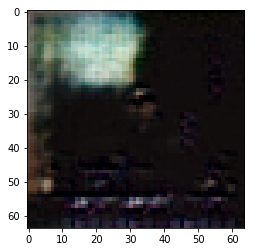

In [24]:
plt.imshow(g_model.predict(np.random.rand(1, 100))[0])

# Training Pipeline

實作GAN順序:
1. 資料準備: 真實資料、生成假資料的維度and分佈
2. 建立Generator
3. 建立Discriminator
4. 訓練D:
    - 4.1 準備好真假圖資料(Input維度)
    - 4.2 G.trainable = False (訓練D)
    - 4.3 把真假圖、Label、Loss、Train法決定好，串起來(Model(Input, Score))並compile
        以上面code來說，因為loss要照WGAN-GP，所以先把真假圖和GP的分數準備好，
        串起來後用add_loss加進模型，再compile
5. 訓練G:
    - 5.1 G.trainable = True, D.trainable = False
    - 5.2 準備好noise(和Label)，讓G生圖給D判別並給予分數D(G(noise)) 
    - 5.3 串起來Model(Input, 假圖分數)，然後compile
6. 開始對抗訓練
    - 6.1 Train D，丟入一樣batch_size的真假樣本，train_on_batch更新(可以for loop Train 5次)
    - 6.2 Train G，丟入batch_size的假樣本，train_on_batch更新，讓它生成的圖真一點
    - 6.3 可配合畫圖函數，固定迭代數畫圖
7. Loss怎麼看?
    - 7.1 D跟G都是越小越好
    - 7.2 G: loss有加負號，值越小表示圖像越逼真(fake_score是高的)
    - 7.3 D: loss也有加負號，真假圖分越開，會負越多；如果是正的代表G的圖反而比較強